In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import torch
import random
import os
import csv

from Config import Config
from Models import KeypointDetectionModel, ConfidenceModel

/Users/julienstal/Library/Python/3.9/lib/python/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.22 (you have 1.4.21). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [4]:
def split_data(data, test_size=0.2, random_seed=None):
    """
    Split dataset into train and test datasets. In our case, datasets are lists of dictionaries which
    contain entries: "Image Name", "x1", "y1", "x2", "y2"
    
    Parameters:
        data (list of dict): The input data to be split.
        test_size (float): Proportion of the dataset to include in the test split (default is 0.2).
        random_seed (int, optional): Random seed for reproducibility (default is None).
    
    Returns:
        tuple: (train_data, test_data) where both are lists of dictionaries.
    """
    if random_seed is not None:
        random.seed(random_seed)
    
    # Shuffle the data
    shuffled_data = data[:]
    random.shuffle(shuffled_data)
    
    # Compute the split index
    split_idx = int(len(shuffled_data) * (1 - test_size))
    
    # Split the data
    train_data = shuffled_data[:split_idx]
    test_data = shuffled_data[split_idx:]
    
    return train_data, test_data

In [5]:
"""
Create datasets by reading the csv files that contain the coordinates.
"""
with open(Config.coords_file_path, mode='r') as file:
    reader = csv.DictReader(file)  # Use DictReader to automatically map rows to dictionaries
    data = [row for row in reader]  # Convert each row into a dictionary and store in a list

train_data, test_data = split_data(data)
print(f"{len(train_data)} training points and {len(test_data)} test points.")

1919 training points and 480 test points.


In [6]:
# Use "mps" to use GPU on macs ("cuda" on non-mac). "cpu" is slower. 
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Training on device: {device}")

Training on device: mps


In [9]:
"""
Create and train keypoint detection model. 
The KeypointDetection Model (KPD) takes images as inputs and learns to find the two points defining Weber's length.
Note: we keep track and restore the best performing version on the test dataset to avoid overfitting
"""
kpd_model = KeypointDetectionModel.KeypointDetectionModel().to(device)
KeypointDetectionModel.train_kpd_model(kpd_model, train_data, test_data, 50, 480, 801)

Epoch 0: test loss = 0.0704583153128624, lr = 9.900000000000001e-05
Epoch 50: test loss = 0.0043894401751458645, lr = 5.9895600646616125e-05
Epoch 100: test loss = 0.002980334684252739, lr = 3.62372017860497e-05
Epoch 150: test loss = 0.0024073796812444925, lr = 2.1923726936647233e-05
Epoch 200: test loss = 0.0022846765350550413, lr = 1.326398781093821e-05
Epoch 250: test loss = 0.0021610702387988567, lr = 8.024793100055947e-06
Epoch 300: test loss = 0.002125527709722519, lr = 4.855048513057286e-06
Epoch 350: test loss = 0.002110747154802084, lr = 2.9373338066467324e-06
Epoch 400: test loss = 0.0020929600577801466, lr = 1.7771047742294685e-06
Epoch 450: test loss = 0.002087702974677086, lr = 1.0751591703479103e-06
Epoch 500: test loss = 0.002081110142171383, lr = 6.50477821199046e-07
Epoch 550: test loss = 0.002078612335026264, lr = 3.9354302836382843e-07
Epoch 600: test loss = 0.0020795008167624474, lr = 2.3809591983979575e-07
Epoch 650: test loss = 0.002078610472381115, lr = 1.440494

In [11]:
best_kpd_state = kpd_model.state_dict()

In [15]:
"""
Create and train the confidence model (same mechanism as above to avoid overfitting).
The confidence model takes images as inputs and outputs a number estimating the error of the KPD model on the given image.
It learns to estimate how hard an image is for the KPD model (for example unusual body shape, too many legs leading to hidden KeyPoint, ...).
The goal is to be able to predict for which images the KPD model can be trusted.
"""
kpd_model.eval()

conf_model = ConfidenceModel.ConfidenceModel().to(device)
# Warning: Some fixes needed, training is useless when using error normalization (would be desirable).
# Also, training is super unpredictable, loss fluctuates and doesn't descend much, is super sensitive to hyperparams... => needs work
ConfidenceModel.train_conf_model(conf_model, kpd_model, train_data, test_data, 500, 480, 61, feedback_rate=10, normalize_errors=False, initial_lr=1e-6, lr_decay=0.97)

Epoch 0: test loss = 0.0005276829469949007, lr = 9.7e-07
Epoch 10: test loss = 2.3163262085290626e-05, lr = 7.153014030880803e-07
Epoch 20: test loss = 3.3578075090190396e-05, lr = 5.274805126389445e-07
Epoch 30: test loss = 2.1098177967360243e-05, lr = 3.8897685648686274e-07
Epoch 40: test loss = 1.6800531739136204e-05, lr = 2.868409187771585e-07
Epoch 50: test loss = 1.714578138489742e-05, lr = 2.1152341408698504e-07
Epoch 60: test loss = 1.702215740806423e-05, lr = 1.5598246895092924e-07


Let's take a look at the predictions the model believes in

Confident predictions:
Error estimation =  0.00021505169570446014


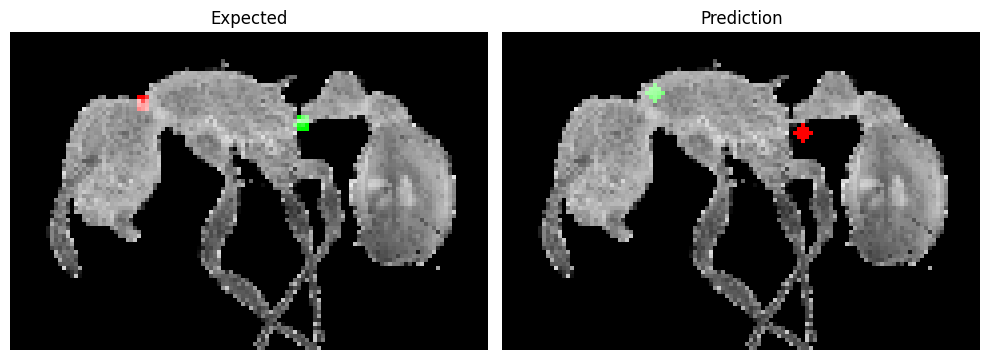

Error estimation =  0.0001320336014032364


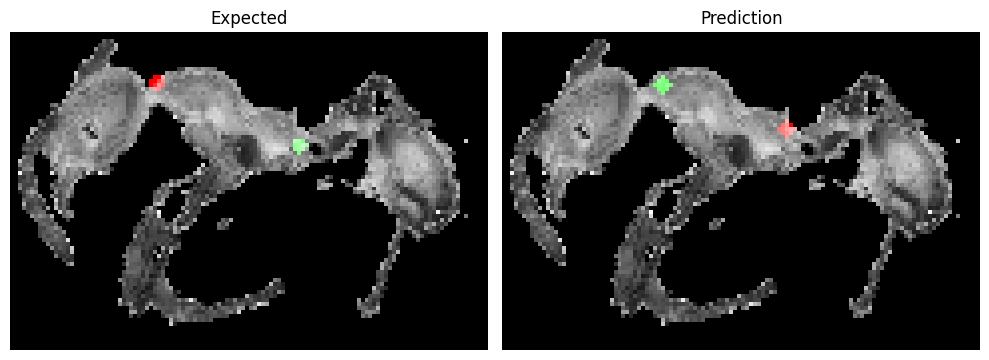

Error estimation =  0.000144109595566988


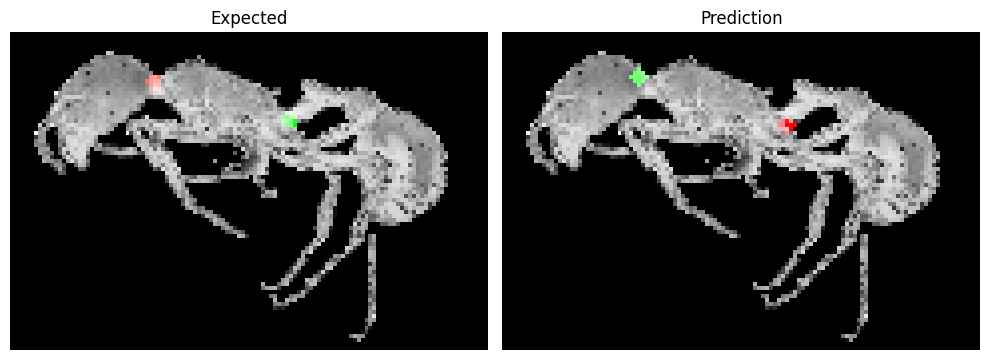

Error estimation =  0.00013143662363290787


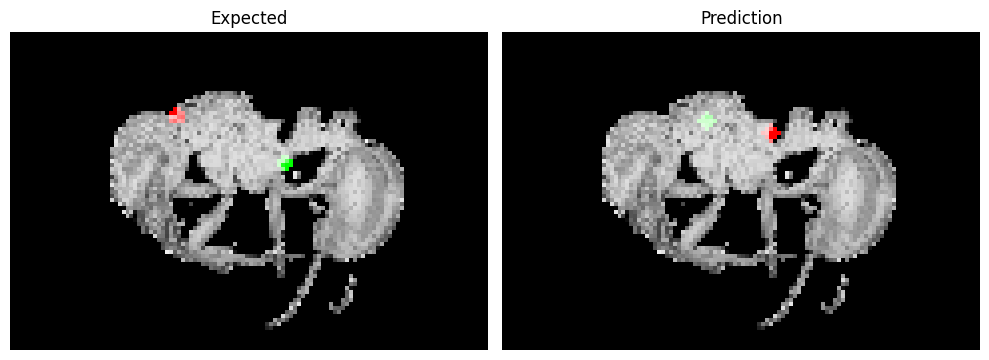

Error estimation =  0.0003248145803809166


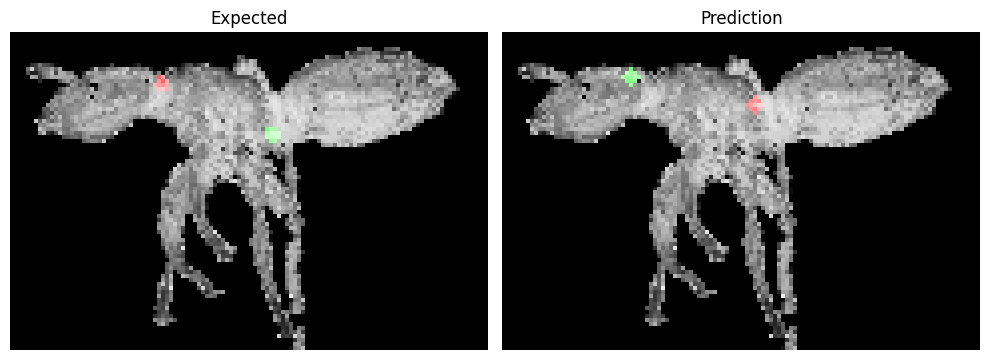

Error estimation =  0.00014955736696720123


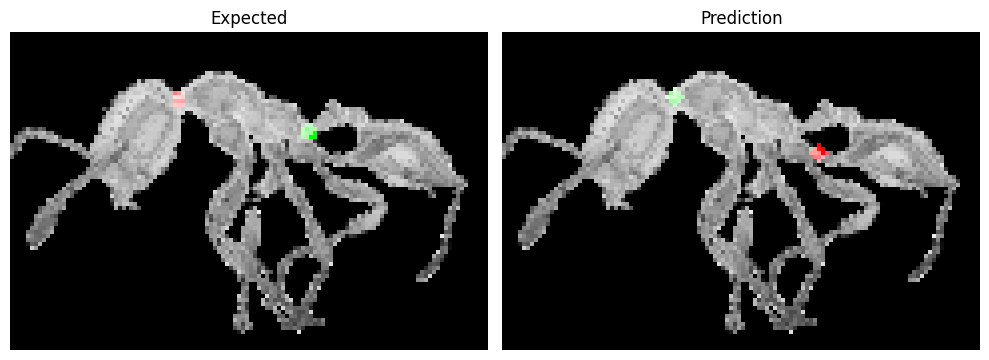

Error estimation =  0.000138875562697649


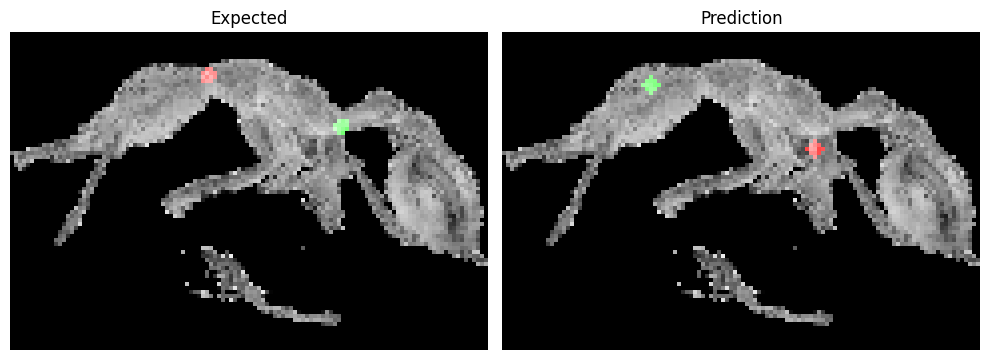

Error estimation =  0.00010456237941980362


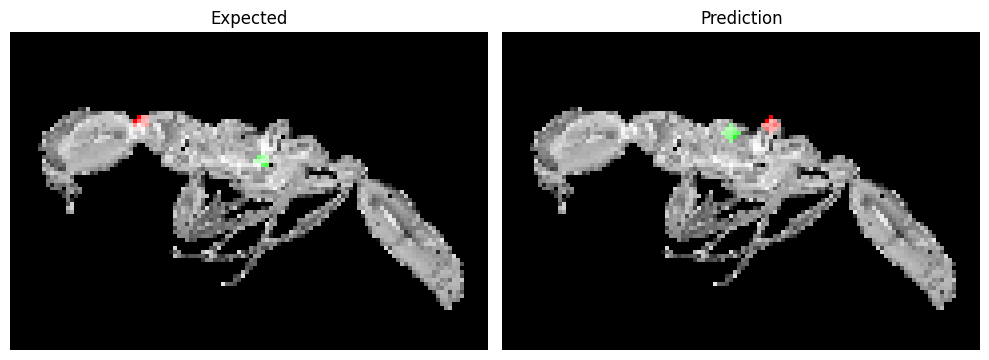

Error estimation =  0.00016656797379255295


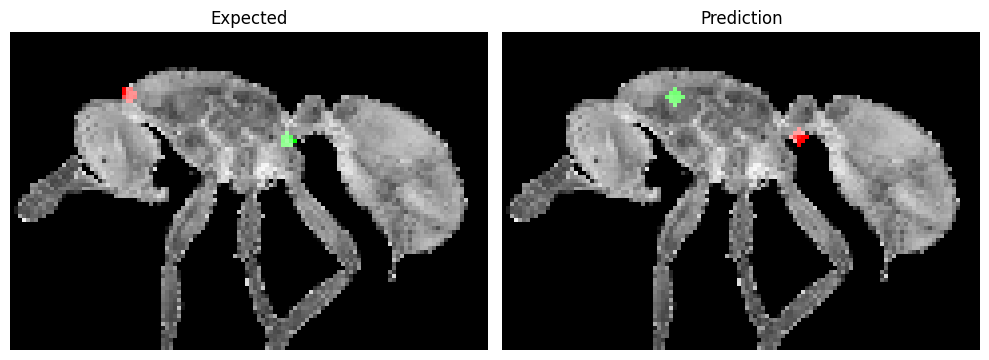

In [17]:
kpd_model.eval()
conf_model.eval()

print("Confident predictions:")
KeypointDetectionModel.plot_model_prediction(kpd_model, test_data, 40, conf_model = conf_model, error_estimation_interval= [0, 0.0005],augment_images=False, device="mps")

And let's take a look at the predictions the model doesn't trust. The model has learned that some patterns in the following images make it hard for the keypoint detection model to be accurate.

Low-confidence predictions:
Error estimation =  0.005573158152401447


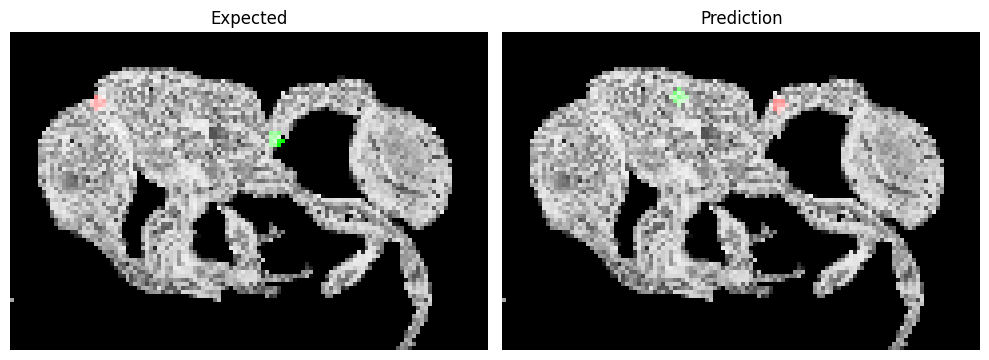

Error estimation =  0.004279048182070255


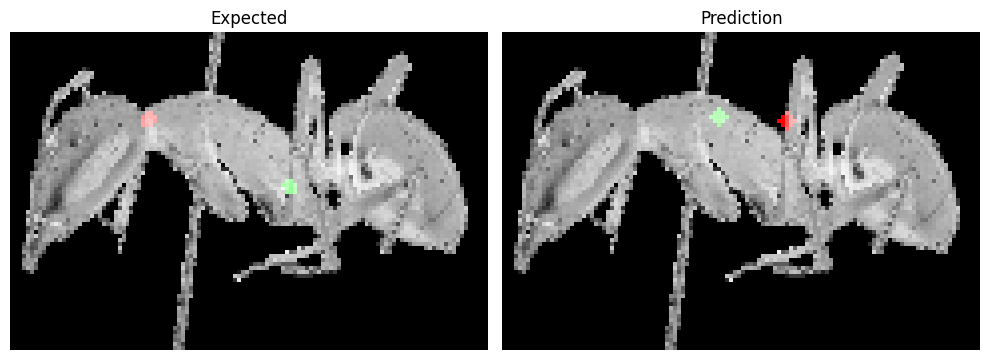

Error estimation =  0.003526344895362854


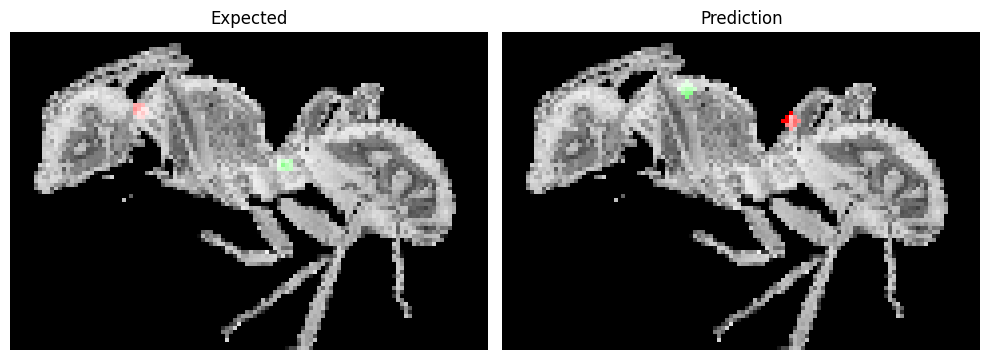

Error estimation =  0.003996034152805805


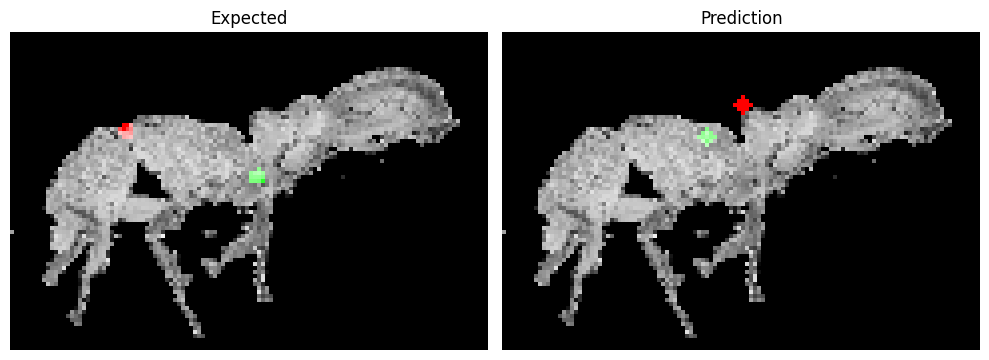

Error estimation =  0.0036470377817749977


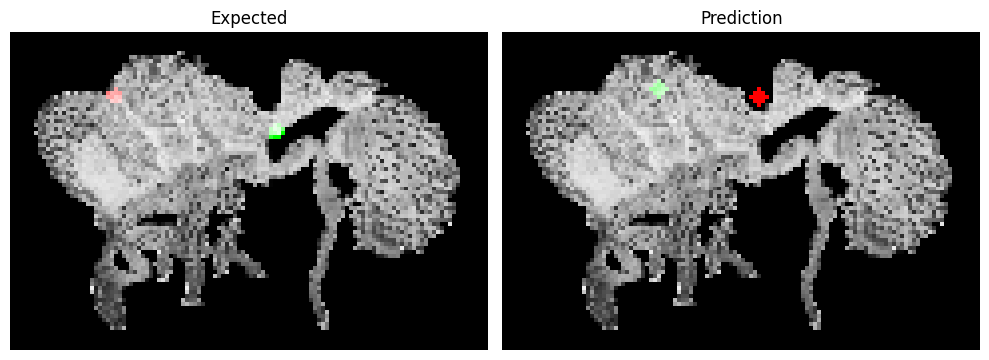

In [22]:
print("Low-confidence predictions:")
KeypointDetectionModel.plot_model_prediction(kpd_model, test_data, 50, conf_model = conf_model, error_estimation_interval= [0.0035, 1],augment_images=False, device="mps")